# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

1. Load CNN dataset.

In [19]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import torchvision
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import zipfile
import random

In [20]:
def set_seed(seed=21):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [23]:
zip_path = 'cnn_part_2_dataset.zip'
extract_path = 'cnn_part_2_dataset'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [24]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

base_dataset = datasets.ImageFolder(extract_path, transform=transform)


Analyze the dataset.

In [37]:
class_names = base_dataset.classes
print(f"Classes: {class_names}")
print(f"Total images: {len(base_dataset)}")

Classes: ['dogs', 'food', 'vehicles']
Total images: 30000


2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

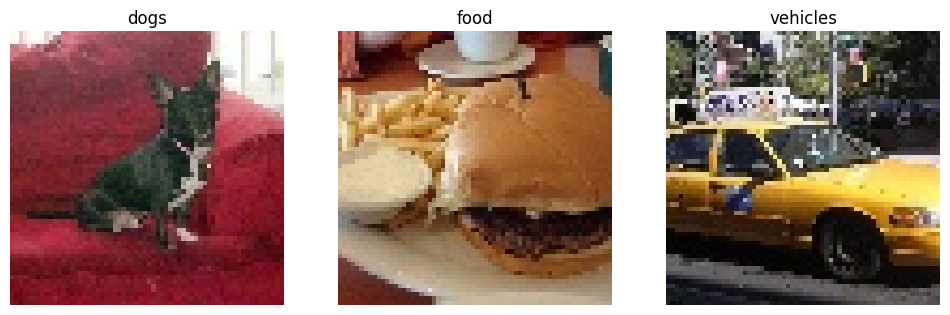

In [ ]:
def show_sample_images(dataset, classes):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for idx, cls in enumerate(classes):
        cls_idx = dataset.class_to_idx[cls]
        images = [img for img, label in dataset if label == cls_idx]
        axes[idx].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))
        axes[idx].set_title(cls)
        axes[idx].axis('off')
    plt.show()

show_sample_images(base_dataset, base_dataset.classes)

The dataset contains 30000 images belonging to 3 different classes ('dogs', 'food', 'vehicles'). THe class distribution is balanced therefore, there is no need for sampling. Pixel Values stand between 0 to 1 (normalized)

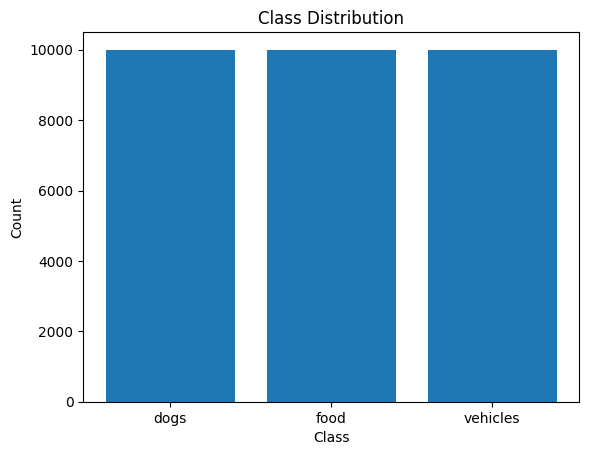

In [ ]:
def plot_class_distribution():
    counts = [0] * len(class_names)
    for _, label in base_dataset:
        counts[label] += 1
    plt.bar(class_names, counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

plot_class_distribution()

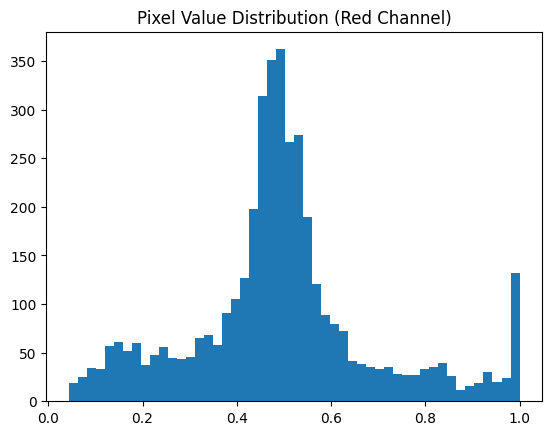

In [ ]:
def plot_histogram():
    sample_img, _ = base_dataset[0]
    plt.hist(sample_img[0].numpy().flatten(), bins=50)
    plt.title("Pixel Value Distribution (Red Channel)")
    plt.show()
plot_histogram()

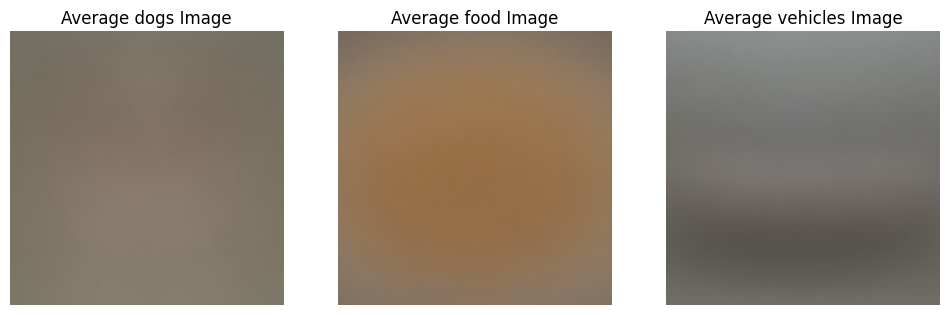

In [ ]:
def compute_average_image(dataset, class_idx):
    images = [img.numpy() for img, label in dataset if label == class_idx]
    avg_img = np.mean(images, axis=0)
    return avg_img

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, cls in enumerate(base_dataset.classes):
    avg_img = compute_average_image(base_dataset, idx)
    axes[idx].imshow(np.transpose(avg_img, (1, 2, 0)))
    axes[idx].set_title(f"Average {cls} Image")
    axes[idx].axis('off')
plt.show()

3. Preprocess the dataset.

The dataset was normalized at the time of laoding. No othere preprocessing is needed here.

4. Split the dataset into training, testing, and validation sets.

In [ ]:
train_size = int(0.7 * len(base_dataset))
val_size = int(0.15 * len(base_dataset))
test_size = len(base_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(base_dataset, [train_size, val_size, test_size])


In [25]:
def get_loaders(batch_size, train_set, val_set, test_set):
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size, shuffle=False),
        DataLoader(test_set, batch_size=batch_size, shuffle=False)
    )

## Step 2: Implementing VGG

1. Implement the VGG-16 (Version C) architecture.

In [26]:
class VGG16(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU()
            # I have removed the final maxpool to accomodate our dataset
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5), #VGG paper section 3.1 sets the droupout as 0.5
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


2. Use dropout and learning rate scheduler. Experiment with weight initialization strategies.

We have added dropout = 0.5 that was specified in the VGG paper section 3.1.


3. Train your VGG-16 model.

In [27]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    epoch_times = []
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            start_time = time.time()
            model.train() if phase == 'train' else model.eval()
            loader = dataloaders[phase]

            running_loss, running_corrects = 0.0, 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase} Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
            end_time = time.time()
            if phase == 'train':
              epoch_times.append(end_time - start_time)

        scheduler.step()

    avg_epoch_time = sum(epoch_times) / len(epoch_times)
    print(f"Average epoch time: {avg_epoch_time:.2f} seconds")
    return model, history


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader):
    model.eval()
    device = next(model.parameters()).device
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification report
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    print("\nPrecision, Recall, F1-score per class:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1={f1[i]:.2f}")

    return test_loss, test_acc.item(), all_preds, all_labels


We have experimented with weight initialization, optimizer, batch sizes and defined the models as follows:

| Model Name  | Weight Initialization | Optimizer | Batch Sizes| Test Accuracy | Per Epoch time |
|-------|-------|-------|-------|-------|-------|
| Model1 | Xavier  | Adam  | 64  | 33.78 % | 37.47 seconds |
| Model2  | He  | Adam  | 64 | 91.98% | 38.83 seconds  |
| Model3 | He  | SGD  | 256  | 87.42%   | 33.40 seconds |
| Model4 | He  | Adam  | 256  | 88.67%  | 33.56 seconds |



1. Weight Initialization : Xavier ; optimizer: Adam

In [ ]:
model1 = VGG16(num_classes=3)
criterion = nn.CrossEntropyLoss()
init_type = 'xavier'
if init_type == 'xavier':
    for m in model1.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model1.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')


optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
scheduler1 = optim.lr_scheduler.StepLR(optimizer1, step_size=5, gamma=0.5)

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader = get_loaders(batch_size, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}

model1, history1 = train_model(model1, criterion, optimizer1, scheduler1, dataloaders, num_epochs=10)


train Epoch 1/10, Loss: 1.1102, Acc: 0.3349
val Epoch 1/10, Loss: 1.0997, Acc: 0.3280
train Epoch 2/10, Loss: 1.0996, Acc: 0.3290
val Epoch 2/10, Loss: 1.0987, Acc: 0.3376
train Epoch 3/10, Loss: 1.0990, Acc: 0.3360
val Epoch 3/10, Loss: 1.0997, Acc: 0.3344
train Epoch 4/10, Loss: 1.0990, Acc: 0.3325
val Epoch 4/10, Loss: 1.0989, Acc: 0.3376
train Epoch 5/10, Loss: 1.0990, Acc: 0.3351
val Epoch 5/10, Loss: 1.0988, Acc: 0.3280
train Epoch 6/10, Loss: 1.0989, Acc: 0.3294
val Epoch 6/10, Loss: 1.0987, Acc: 0.3344
train Epoch 7/10, Loss: 1.0988, Acc: 0.3313
val Epoch 7/10, Loss: 1.0988, Acc: 0.3280
train Epoch 8/10, Loss: 1.0988, Acc: 0.3303
val Epoch 8/10, Loss: 1.0990, Acc: 0.3280
train Epoch 9/10, Loss: 1.0988, Acc: 0.3303
val Epoch 9/10, Loss: 1.0989, Acc: 0.3280
train Epoch 10/10, Loss: 1.0987, Acc: 0.3333
val Epoch 10/10, Loss: 1.0987, Acc: 0.3280
Average epoch time: 37.47 seconds


Test Loss: 1.0985, Test Accuracy: 0.3378


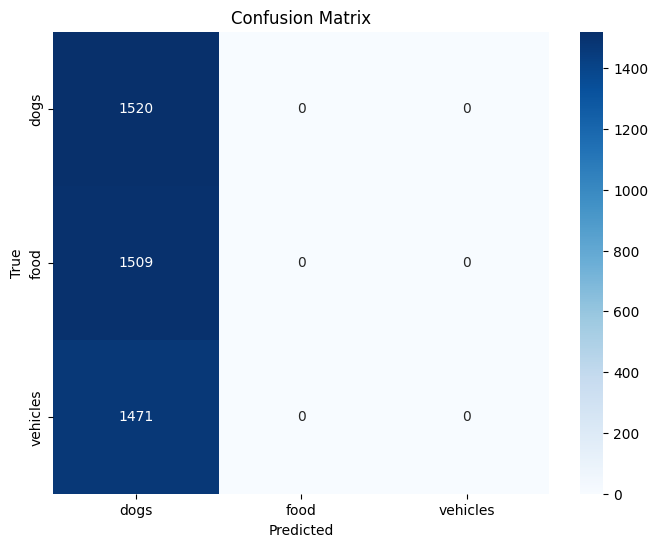


Precision, Recall, F1-score per class:
dogs: Precision=0.34, Recall=1.00, F1=0.50
food: Precision=0.00, Recall=0.00, F1=0.00
vehicles: Precision=0.00, Recall=0.00, F1=0.00


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(model1, test_loader)

In [ ]:
import gc
del model1
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

2. Weight Initialization : he ; optimizer: Adam

In [35]:
model2 = VGG16(num_classes=3)
criterion = nn.CrossEntropyLoss()
init_type = 'he'
if init_type == 'xavier':
    for m in model2.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model2.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=5, gamma=0.5)

In [ ]:
batch_size = 64
train_loader, val_loader, test_loader = get_loaders(batch_size, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}

model2, history2 = train_model(model2, criterion, optimizer2, scheduler2, dataloaders, num_epochs=10)

train Epoch 1/10, Loss: 2.7584, Acc: 0.5460
val Epoch 1/10, Loss: 0.5705, Acc: 0.7689
train Epoch 2/10, Loss: 0.4805, Acc: 0.8174
val Epoch 2/10, Loss: 0.3688, Acc: 0.8562
train Epoch 3/10, Loss: 0.3733, Acc: 0.8608
val Epoch 3/10, Loss: 0.4060, Acc: 0.8727
train Epoch 4/10, Loss: 0.3131, Acc: 0.8875
val Epoch 4/10, Loss: 0.3435, Acc: 0.8727
train Epoch 5/10, Loss: 0.2746, Acc: 0.9024
val Epoch 5/10, Loss: 0.2655, Acc: 0.9087
train Epoch 6/10, Loss: 0.2042, Acc: 0.9267
val Epoch 6/10, Loss: 0.2442, Acc: 0.9084
train Epoch 7/10, Loss: 0.1720, Acc: 0.9370
val Epoch 7/10, Loss: 0.2253, Acc: 0.9249
train Epoch 8/10, Loss: 0.1590, Acc: 0.9403
val Epoch 8/10, Loss: 0.2320, Acc: 0.9162
train Epoch 9/10, Loss: 0.1356, Acc: 0.9510
val Epoch 9/10, Loss: 0.2285, Acc: 0.9233
train Epoch 10/10, Loss: 0.1243, Acc: 0.9560
val Epoch 10/10, Loss: 0.2754, Acc: 0.9073
Average epoch time: 38.83 seconds


Test Loss: 0.2387, Test Accuracy: 0.9198


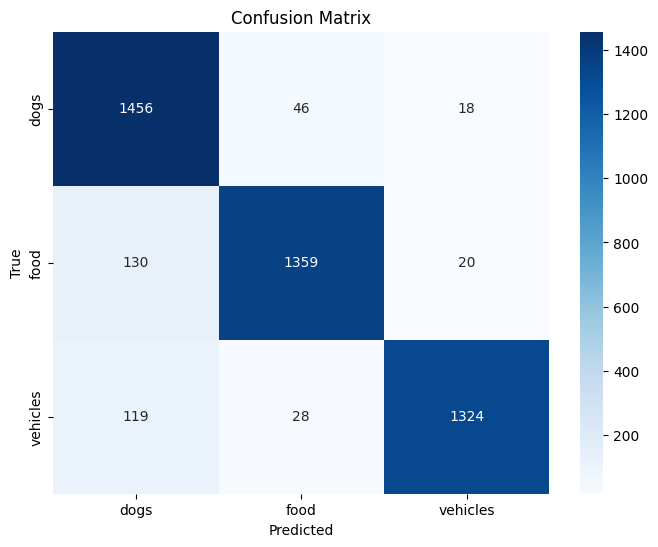


Precision, Recall, F1-score per class:
dogs: Precision=0.85, Recall=0.96, F1=0.90
food: Precision=0.95, Recall=0.90, F1=0.92
vehicles: Precision=0.97, Recall=0.90, F1=0.93


In [ ]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(model2, test_loader)

 3. Weight Initialization : he ; optimizer: SGD

In [ ]:
model3 = VGG16(num_classes=3)
criterion = nn.CrossEntropyLoss()
init_type = 'he'
if init_type == 'xavier':
    for m in model3.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model3.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

optimizer3 = optim.SGD(model3.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler3 = optim.lr_scheduler.StepLR(optimizer3, step_size=5, gamma=0.5)

In [ ]:
batch_size_3 = 256
train_loader, val_loader, test_loader = get_loaders(batch_size_3, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}

model3, history3 = train_model(model3, criterion, optimizer3, scheduler3, dataloaders, num_epochs=10)

train Epoch 1/10, Loss: 1.1527, Acc: 0.3948
val Epoch 1/10, Loss: 1.0912, Acc: 0.3416
train Epoch 2/10, Loss: 0.9913, Acc: 0.4924
val Epoch 2/10, Loss: 0.7727, Acc: 0.6240
train Epoch 3/10, Loss: 0.5962, Acc: 0.7540
val Epoch 3/10, Loss: 0.7719, Acc: 0.6827
train Epoch 4/10, Loss: 0.4915, Acc: 0.7975
val Epoch 4/10, Loss: 0.5782, Acc: 0.7733
train Epoch 5/10, Loss: 0.4430, Acc: 0.8250
val Epoch 5/10, Loss: 0.5382, Acc: 0.7824
train Epoch 6/10, Loss: 0.3822, Acc: 0.8476
val Epoch 6/10, Loss: 0.4941, Acc: 0.8164
train Epoch 7/10, Loss: 0.3681, Acc: 0.8551
val Epoch 7/10, Loss: 0.3560, Acc: 0.8660
train Epoch 8/10, Loss: 0.3381, Acc: 0.8708
val Epoch 8/10, Loss: 0.3627, Acc: 0.8684
train Epoch 9/10, Loss: 0.3367, Acc: 0.8692
val Epoch 9/10, Loss: 0.4153, Acc: 0.8389
train Epoch 10/10, Loss: 0.3080, Acc: 0.8831
val Epoch 10/10, Loss: 0.3420, Acc: 0.8729
Average epoch time: 33.40 seconds


Test Loss: 0.3311, Test Accuracy: 0.8742


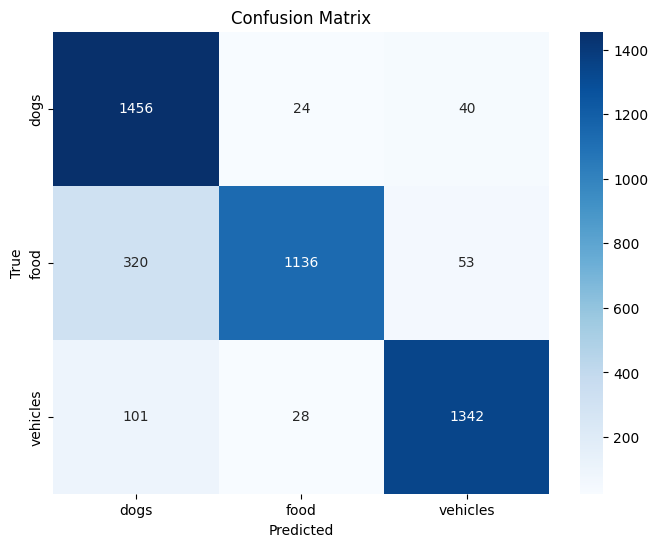


Precision, Recall, F1-score per class:
dogs: Precision=0.78, Recall=0.96, F1=0.86
food: Precision=0.96, Recall=0.75, F1=0.84
vehicles: Precision=0.94, Recall=0.91, F1=0.92


In [ ]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(model3, test_loader)

In [ ]:
del model3
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

4. Weight Initialization : he ; optimizer: Adam ; Batch size = 256 (as specified in the vgg paper)

In [ ]:
model4 = VGG16(num_classes=3)
criterion = nn.CrossEntropyLoss()

init_type = 'he'
if init_type == 'xavier':
    for m in model4.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model4.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')


optimizer4 = optim.Adam(model4.parameters(), lr=0.001)
scheduler4 = optim.lr_scheduler.StepLR(optimizer4, step_size=5, gamma=0.5)

In [ ]:
batch_size_4 = 256
train_loader, val_loader, test_loader = get_loaders(batch_size_4, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}
model4, history4 = train_model(model4, criterion, optimizer4, scheduler4, dataloaders, num_epochs=10)

train Epoch 1/10, Loss: 4.2362, Acc: 0.3842
val Epoch 1/10, Loss: 0.9867, Acc: 0.4887
train Epoch 2/10, Loss: 1.0181, Acc: 0.4584
val Epoch 2/10, Loss: 0.9016, Acc: 0.6089
train Epoch 3/10, Loss: 0.7076, Acc: 0.6959
val Epoch 3/10, Loss: 0.6670, Acc: 0.7191
train Epoch 4/10, Loss: 0.5169, Acc: 0.7894
val Epoch 4/10, Loss: 0.4659, Acc: 0.8138
train Epoch 5/10, Loss: 0.4375, Acc: 0.8296
val Epoch 5/10, Loss: 0.4386, Acc: 0.8309
train Epoch 6/10, Loss: 0.3489, Acc: 0.8696
val Epoch 6/10, Loss: 0.3497, Acc: 0.8629
train Epoch 7/10, Loss: 0.3065, Acc: 0.8857
val Epoch 7/10, Loss: 0.3465, Acc: 0.8609
train Epoch 8/10, Loss: 0.2826, Acc: 0.8925
val Epoch 8/10, Loss: 0.3209, Acc: 0.8771
train Epoch 9/10, Loss: 0.2564, Acc: 0.9037
val Epoch 9/10, Loss: 0.4077, Acc: 0.8449
train Epoch 10/10, Loss: 0.2435, Acc: 0.9091
val Epoch 10/10, Loss: 0.3118, Acc: 0.8818
Average epoch time: 33.56 seconds


Test Loss: 0.2996, Test Accuracy: 0.8867


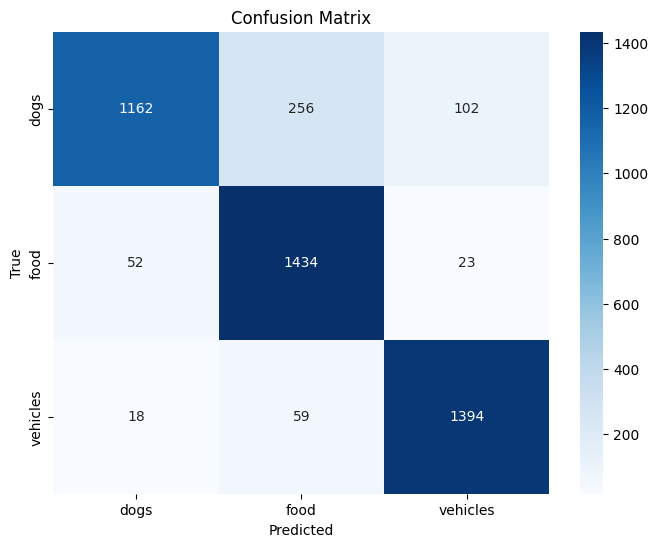


Precision, Recall, F1-score per class:
dogs: Precision=0.94, Recall=0.76, F1=0.84
food: Precision=0.82, Recall=0.95, F1=0.88
vehicles: Precision=0.92, Recall=0.95, F1=0.93


In [ ]:
test_loss, test_acc, all_preds, all_labels = evaluate_model(model4, test_loader)

In [ ]:
del model4
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

4. Apply regularization and overfitting prevention techniques.

In [ ]:
transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

aug_dataset = datasets.ImageFolder(extract_path, transform=transform_aug)

In [31]:
train_size = int(0.7 * len(aug_dataset))
val_size = int(0.15 * len(aug_dataset))
test_size = len(aug_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(aug_dataset, [train_size, val_size, test_size])


#### Improved VGG: Final

In [32]:
model2_reg = VGG16(num_classes=3)
criterion2_reg = nn.CrossEntropyLoss(label_smoothing=0.1)
init_type = 'he'
if init_type == 'xavier':
    for m in model2_reg.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model2_reg.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

optimizer2_reg = optim.Adam(model2_reg.parameters(), lr=0.001, weight_decay=1e-4)
scheduler2_reg = optim.lr_scheduler.StepLR(optimizer2_reg, step_size=5, gamma=0.5)

In [33]:
batch_size = 64
train_loader, val_loader, test_loader = get_loaders(batch_size, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}

model2_reg, history2_reg = train_model(model2_reg, criterion2_reg, optimizer2_reg, scheduler2_reg, dataloaders, num_epochs=40)

train Epoch 1/40, Loss: 1.6319, Acc: 0.4017
val Epoch 1/40, Loss: 0.8887, Acc: 0.6133
train Epoch 2/40, Loss: 0.7431, Acc: 0.7393
val Epoch 2/40, Loss: 0.7527, Acc: 0.7240
train Epoch 3/40, Loss: 0.6460, Acc: 0.7964
val Epoch 3/40, Loss: 0.6117, Acc: 0.8180
train Epoch 4/40, Loss: 0.5932, Acc: 0.8337
val Epoch 4/40, Loss: 0.5659, Acc: 0.8456
train Epoch 5/40, Loss: 0.5567, Acc: 0.8597
val Epoch 5/40, Loss: 0.5698, Acc: 0.8396
train Epoch 6/40, Loss: 0.5027, Acc: 0.8870
val Epoch 6/40, Loss: 0.4978, Acc: 0.8871
train Epoch 7/40, Loss: 0.4893, Acc: 0.8921
val Epoch 7/40, Loss: 0.4657, Acc: 0.9047
train Epoch 8/40, Loss: 0.4729, Acc: 0.9024
val Epoch 8/40, Loss: 0.4969, Acc: 0.8858
train Epoch 9/40, Loss: 0.4633, Acc: 0.9077
val Epoch 9/40, Loss: 0.4755, Acc: 0.9016
train Epoch 10/40, Loss: 0.4589, Acc: 0.9111
val Epoch 10/40, Loss: 0.4489, Acc: 0.9116
train Epoch 11/40, Loss: 0.4320, Acc: 0.9250
val Epoch 11/40, Loss: 0.4401, Acc: 0.9178
train Epoch 12/40, Loss: 0.4301, Acc: 0.9261
val E

Test Loss: 0.2063, Test Accuracy: 0.9411


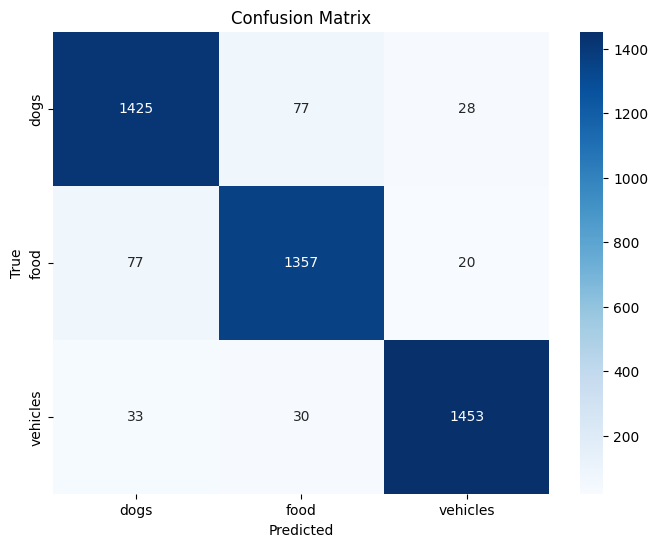


Precision, Recall, F1-score per class:
dogs: Precision=0.93, Recall=0.93, F1=0.93
food: Precision=0.93, Recall=0.93, F1=0.93
vehicles: Precision=0.97, Recall=0.96, F1=0.96


In [38]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, all_preds, all_labels = evaluate_model(model2_reg, test_loader)

5. Evaluation and analysis.

In [39]:
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



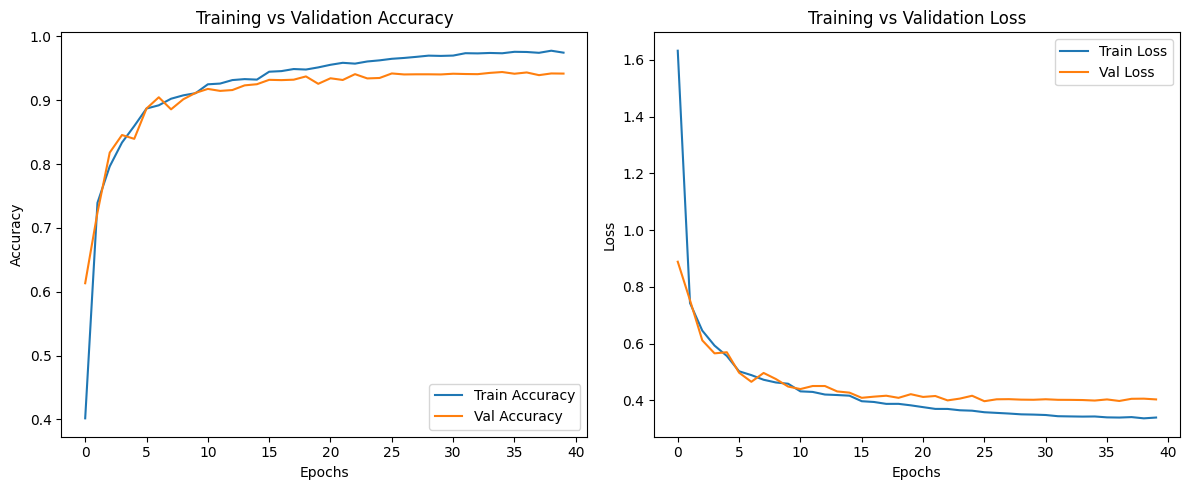

In [40]:
plot_training_curves(history2_reg)

Both the plots converge accurately

In [41]:
def show_misclassified(model, dataloader, num_images=8):
    model.eval()
    device = next(model.parameters()).device
    misclassified = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((inputs[i].cpu(), preds[i].cpu(), labels[i].cpu()))
                if len(misclassified) >= num_images:
                    break
            if len(misclassified) >= num_images:
                break

    plt.figure(figsize=(15, 5))
    for i, (img, pred, label) in enumerate(misclassified):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.permute(1, 2, 0), cmap="gray")
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
        plt.axis('off')
    plt.suptitle("Misclassified Images")
    plt.show()


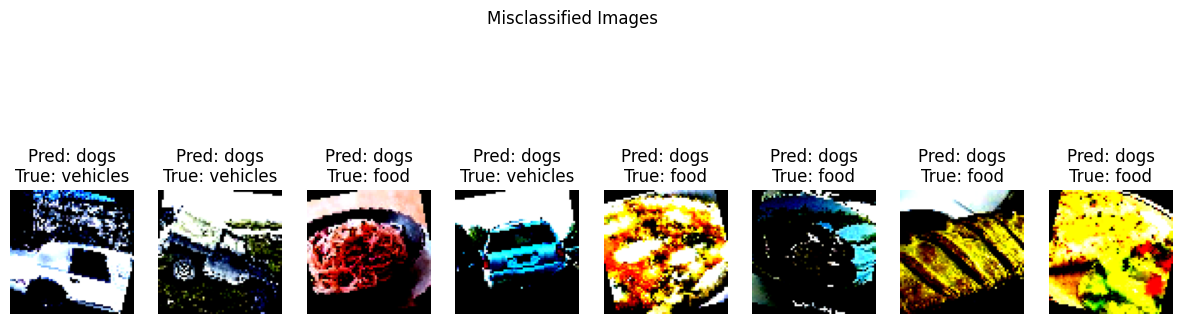

In [42]:
show_misclassified(model2, test_loader)

Model misclassified images that were actually hard to classify

6. Save the weights of the trained network.

In [43]:
torch.save(model2_reg.state_dict(), 'a1_part2_vgg_aarushij_singh72.pth')


In [ ]:
del model2
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

In [ ]:
del model2_reg
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

2. Assemble the ResNet-18 architecture.

In [45]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


3. Train the ResNet-18 model.

In [46]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            loader = dataloaders[phase]

            running_loss, running_corrects = 0.0, 0
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())
            print(f"{phase} Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        scheduler.step()
    return model, history

In [47]:
def evaluate_model(model, test_loader):
    model.eval()
    device = next(model.parameters()).device
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())

    correct = sum(p == t for p, t in zip(y_pred, y_true))
    total = len(y_true)
    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i, cls in enumerate(class_names):
        print(f"{cls} → Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1: {f1[i]:.2f}")

In [ ]:
model_resnet = ResNet18(num_classes=3)
init_type = 'he'
if init_type == 'xavier':
    for m in model_resnet.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model_resnet.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
train_loader, val_loader, test_loader = get_loaders(batch_size, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}
model_resnet, history = train_model(model_resnet, criterion, optimizer, scheduler, dataloaders, num_epochs=10)

train Epoch 1/10, Loss: 0.5433, Acc: 0.7934
val Epoch 1/10, Loss: 0.7777, Acc: 0.6651
train Epoch 2/10, Loss: 0.3682, Acc: 0.8605
val Epoch 2/10, Loss: 0.3518, Acc: 0.8740
train Epoch 3/10, Loss: 0.2998, Acc: 0.8863
val Epoch 3/10, Loss: 0.2971, Acc: 0.8869
train Epoch 4/10, Loss: 0.2631, Acc: 0.9006
val Epoch 4/10, Loss: 0.2739, Acc: 0.9107
train Epoch 5/10, Loss: 0.2358, Acc: 0.9139
val Epoch 5/10, Loss: 0.3299, Acc: 0.8802
train Epoch 6/10, Loss: 0.1884, Acc: 0.9291
val Epoch 6/10, Loss: 0.2014, Acc: 0.9256
train Epoch 7/10, Loss: 0.1772, Acc: 0.9328
val Epoch 7/10, Loss: 0.2069, Acc: 0.9273
train Epoch 8/10, Loss: 0.1770, Acc: 0.9327
val Epoch 8/10, Loss: 0.1879, Acc: 0.9293
train Epoch 9/10, Loss: 0.1632, Acc: 0.9366
val Epoch 9/10, Loss: 0.1889, Acc: 0.9316
train Epoch 10/10, Loss: 0.1642, Acc: 0.9392
val Epoch 10/10, Loss: 0.1567, Acc: 0.9433


Test Accuracy: 94.49%


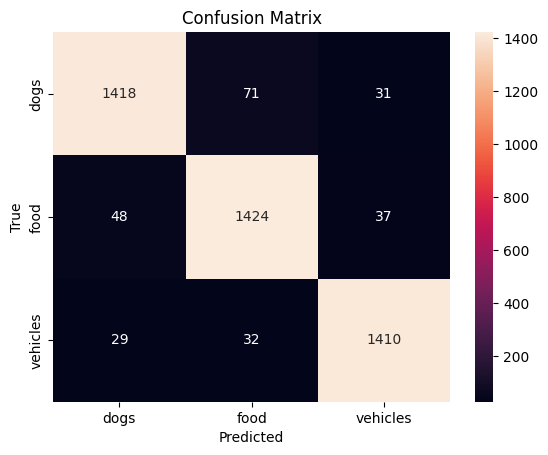

dogs → Precision: 0.95, Recall: 0.93, F1: 0.94
food → Precision: 0.93, Recall: 0.94, F1: 0.94
vehicles → Precision: 0.95, Recall: 0.96, F1: 0.96


In [ ]:
evaluate_model(model_resnet, test_loader)

In [ ]:
del model_resnet
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
set_seed()

4. Apply regularization techniques.

In [48]:
model_resnet_reg = ResNet18(num_classes=3)
batch_size = 64
train_loader, val_loader, test_loader = get_loaders(batch_size, train_set, val_set, test_set)
dataloaders = {"train": train_loader, "val": val_loader}
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)
init_type = 'he'
if init_type == 'xavier':
    for m in model_resnet_reg.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
elif init_type == 'he':
    for m in model_resnet_reg.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

optimizer_resnet_reg = optim.Adam(model_resnet_reg.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_resnet_reg = optim.lr_scheduler.StepLR(optimizer_resnet_reg, step_size=5, gamma=0.5)
model_resnet_reg, history_resnet_reg = train_model(model_resnet_reg, criterion_2, optimizer_resnet_reg, scheduler_resnet_reg, dataloaders, num_epochs=40)


train Epoch 1/40, Loss: 0.7001, Acc: 0.7800
val Epoch 1/40, Loss: 0.5978, Acc: 0.8316
train Epoch 2/40, Loss: 0.5683, Acc: 0.8510
val Epoch 2/40, Loss: 0.5668, Acc: 0.8498
train Epoch 3/40, Loss: 0.5308, Acc: 0.8754
val Epoch 3/40, Loss: 0.5857, Acc: 0.8431
train Epoch 4/40, Loss: 0.5005, Acc: 0.8896
val Epoch 4/40, Loss: 0.5452, Acc: 0.8709
train Epoch 5/40, Loss: 0.4820, Acc: 0.9021
val Epoch 5/40, Loss: 0.4811, Acc: 0.9080
train Epoch 6/40, Loss: 0.4516, Acc: 0.9181
val Epoch 6/40, Loss: 0.4454, Acc: 0.9200
train Epoch 7/40, Loss: 0.4452, Acc: 0.9201
val Epoch 7/40, Loss: 0.4819, Acc: 0.9000
train Epoch 8/40, Loss: 0.4375, Acc: 0.9237
val Epoch 8/40, Loss: 0.4875, Acc: 0.9018
train Epoch 9/40, Loss: 0.4322, Acc: 0.9270
val Epoch 9/40, Loss: 0.4445, Acc: 0.9207
train Epoch 10/40, Loss: 0.4297, Acc: 0.9307
val Epoch 10/40, Loss: 0.4708, Acc: 0.9109
train Epoch 11/40, Loss: 0.4080, Acc: 0.9415
val Epoch 11/40, Loss: 0.4128, Acc: 0.9347
train Epoch 12/40, Loss: 0.3985, Acc: 0.9466
val E

Test Accuracy: 96.38%


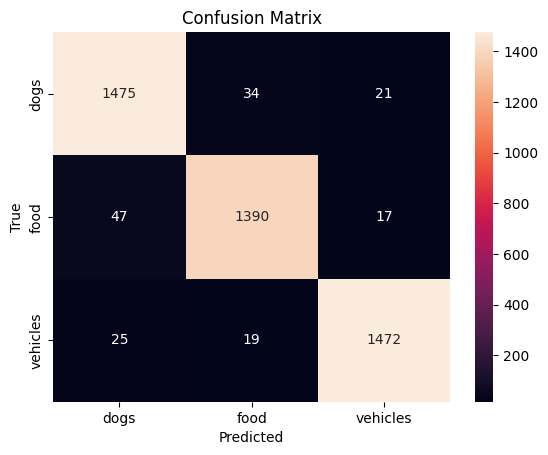

dogs → Precision: 0.95, Recall: 0.96, F1: 0.96
food → Precision: 0.96, Recall: 0.96, F1: 0.96
vehicles → Precision: 0.97, Recall: 0.97, F1: 0.97


In [49]:
evaluate_model(model_resnet_reg, test_loader)

5. Evaluation and analysis.

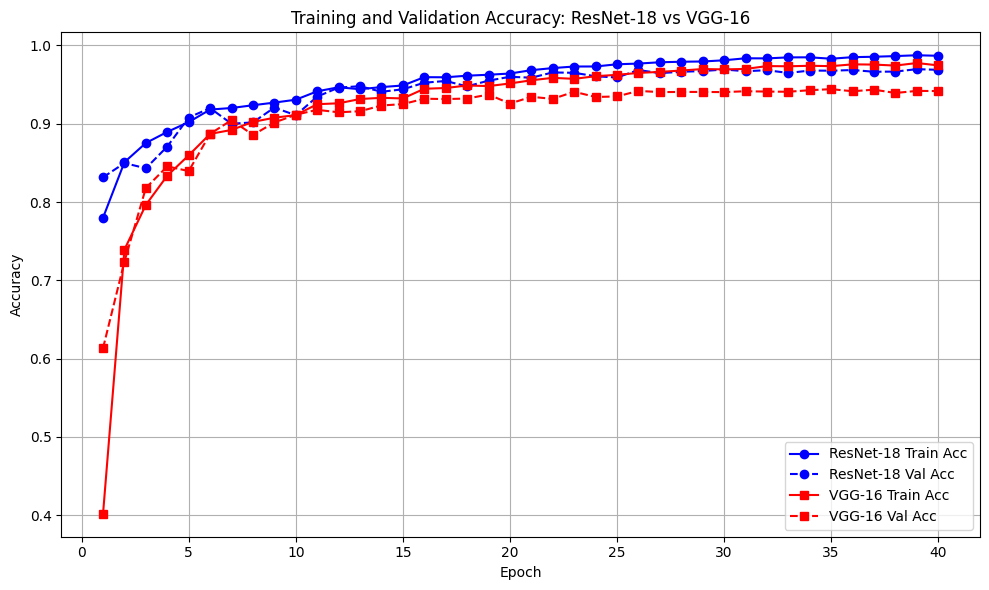

In [50]:
import matplotlib.pyplot as plt

# Extract values from training history
epochs = range(1, len(history_resnet_reg['train_loss']) + 1)

# Plot 1: Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_resnet_reg['train_acc'], 'b-o', label='ResNet-18 Train Acc')
plt.plot(epochs, history_resnet_reg['val_acc'], 'b--o', label='ResNet-18 Val Acc')
plt.plot(epochs, history2_reg['train_acc'], 'r-s', label='VGG-16 Train Acc')
plt.plot(epochs, history2_reg['val_acc'], 'r--s', label='VGG-16 Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy: ResNet-18 vs VGG-16')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



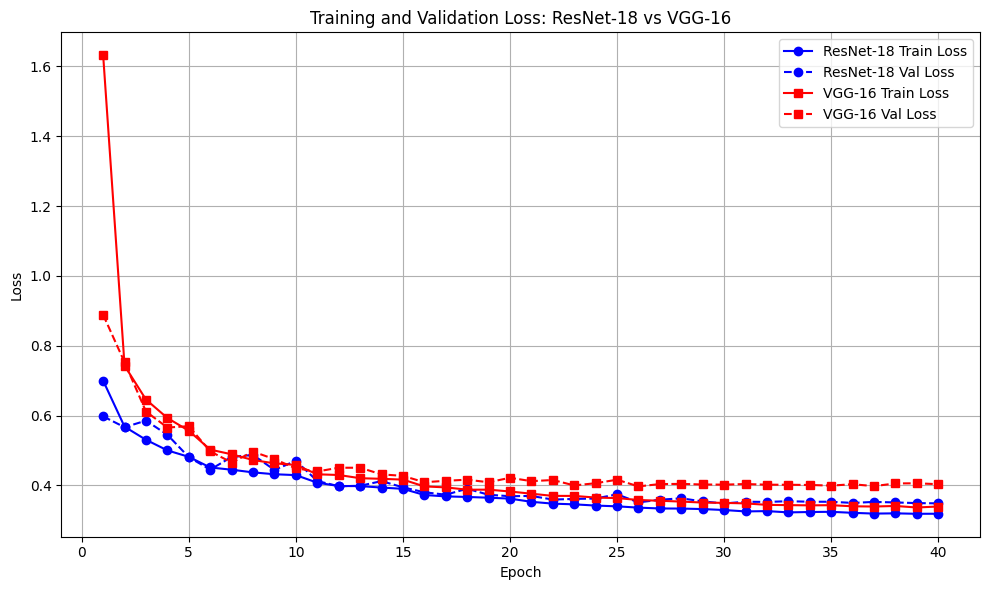

In [51]:
# Plot 2: Loss Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history_resnet_reg['train_loss'], 'b-o', label='ResNet-18 Train Loss')
plt.plot(epochs, history_resnet_reg['val_loss'], 'b--o', label='ResNet-18 Val Loss')
plt.plot(epochs, history2_reg['train_loss'], 'r-s', label='VGG-16 Train Loss')
plt.plot(epochs, history2_reg['val_loss'], 'r--s', label='VGG-16 Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss: ResNet-18 vs VGG-16')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


6. Save the weights of the trained network.

In [52]:
torch.save(model_resnet_reg.state_dict(), 'a1_part2_resnet_aarushij_singh72.pth')


## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.



*   VGG implements deeper CNN
architecture with stacking of smaller filters. This ensures fewer parameters and increased non-linearlity which imporves learning.
*   Deep NN suffer from vanishing/exploding gradients which affects the performance (accuracy)  as well as slows convergence. ResNet mitigates this by introducing residual connections. ResNet implements identity mapping which directly passes the input to output without chnages.





2. Discuss the impact of regularization and optimization techniques.



*  Optimizers:

1.   SGD: SGD did not work well for VGG especially with the large batch size of 256
2.   Adam: Adam performed reasonally well.


*   Regularisation:

1.   Image augmentation: horizontal flip, rotation, and color jitter and normalization using the ImageNet mean and std
2.   weight deacy: 1e-4
3.  increased number of epochs from 10 to 40

These regularizations have performed well for the vgg model increasing the test accuracy




3. Analyze the results, including all required graphs and metrics.

The last 2 graphs suggest that resNet has perfromed consistently better than VGG considering all the metrics.

4. Summarize your findings and discuss the advantages of residual connections.

Our findings show that ResNet performs better than VGG in both accuracy and training time. Residual connections allow gradients to flow more easily through the network, mitigating the vanishing gradient problem and thus the model converges faster. This leads to improved performance and better generalization compared to VGG.

5. References.


* DL basics


  1.  https://docs.pytorch.org/tutorials/beginner/introyt/introyt_index.html
  2.  https://www.geeksforgeeks.org/building-a-convolutional-neural-network-using-pytorch/

*   VGG

  1.   VGG Paper https://arxiv.org/pdf/1409.1556
  2.   https://www.geeksforgeeks.org/vgg-16-cnn-model/


*   Pytorch Transforms
 https://docs.pytorch.org/vision/stable/transforms.html

* Scheduler
https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

* Training with Pytoch
https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html

* Precision,Recall,Fscore
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

* Weight Initialization

  1.   https://www.geeksforgeeks.org/initialize-weights-in-pytorch/
  2.   https://docs.pytorch.org/docs/stable/nn.init.html

* Optimization
https://docs.pytorch.org/docs/main/optim.html

* Regularization
  1.   Label Smoothing in CrossEntropyLoss https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
  2.   Weight Decay https://docs.pytorch.org/docs/main/optim.html
  

* ResNet


  1.   ResNet Paper
  https://arxiv.org/pdf/1512.03385
  2.   https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/

* Google Colab's inbuilt AI assisstant Gemini was used for debugging.


| Teammate| Contribution |
|----------|----------|
|Aarushi Jugran   | 50%  |
|Anukriti Singh   | 50%  |


Aarushi worked on the initial preprocessing of the dataset, setting up the foundation for model training. Anukriti focused on experimenting with various VGG architectures and fine-tuning their performance. Subsequently, Aarushi implemented the ResNet model using the best-performing hyperparameters derived from the VGG experiments.

Note: The contributions listed above reflect the coding aspects of the project. Both team members actively participated in discussions, research, and ideation throughout the development of all models, including VGG and ResNet.
